In [1]:
# Load libraries


import pandas as pd
from matplotlib import pyplot
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC


import numpy as np
import pandas as pd
import json
import os
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm
from datetime import datetime
#sns.set_style('white')


# DroughtTrack ML
By Andreas Tsantilas, Jan Kolupaev, Benjamin Grass, and Rishabh Raniwala

## Part I: Cleaning the Data

In [2]:
import os
files = {}

for dirname, _, filenames in os.walk('./'):
    for filename in filenames:
        if 'train' in filename:
            files['train'] = os.path.join(dirname, filename)
        if 'valid' in filename:
            files['valid'] = os.path.join(dirname, filename)
        if 'test_t' in filename:
            files['test'] = os.path.join(dirname, filename)

Our first job is to import the data, and create a dictionary containing each of the dataframes. 

In [3]:
files

{'test': './test_timeseries.csv',
 'train': './train_timeseries.csv',
 'valid': './validation_timeseries.csv'}

In [4]:
dfs = {
    k: pd.read_csv(files[k]).set_index(['fips', 'date'])
    for k in files.keys()
}

In [5]:
dfs['train']

PRECTOT      PS   QV2M    T2M  T2MDEW  T2MWET  T2M_MAX  \
fips  date                                                                 
1001  2000-01-01     0.22  100.51   9.65  14.74   13.51   13.51    20.96   
      2000-01-02     0.20  100.55  10.42  16.69   14.71   14.71    22.80   
      2000-01-03     3.65  100.15  11.76  18.49   16.52   16.52    22.73   
      2000-01-04    15.95  100.29   6.42  11.40    6.09    6.10    18.09   
      2000-01-05     0.00  101.15   2.95   3.86   -3.29   -3.20    10.82   
...                   ...     ...    ...    ...     ...     ...      ...   
56043 2016-12-27     0.16   82.88   1.63  -7.97  -13.49  -12.81    -1.39   
      2016-12-28     0.02   83.33   1.41  -8.71  -14.10  -13.84    -2.49   
      2016-12-29     0.00   83.75   1.59  -7.96  -13.30  -13.03     0.42   
      2016-12-30     1.22   82.49   2.63  -2.94   -7.40   -7.33     3.76   
      2016-12-31     0.44   82.19   1.75  -7.56  -11.98  -11.82    -0.95   

                  T2M_MIN  T2M_RANGE     TS  WS10M  WS10M_MAX  WS10M_MIN  \
fips  date                                                                 
1001  2000-01-01    11.46       9.50  14.65   2.20       2.94       1.49   
      2000-01-02    12.61      10.18  16.60   2.52       3.43       1.83   
      2000-01-03    15.32       7.41  18.41   4.03       5.33       2.66   
      2000-01-04     2.16      15.92  11.31   3.84       5.67       2.08   
      2000-01-05    -2.66      13.48   2.65   1.60       2.50       0.52   
...                   ...        ...    ...    ...        ...        ...   
56043 2016-12-27   -13.60      12.21  -9.41   5.90       7.63       3.61   
      2016-12-28   -13.56      11.07 -10.55   6.50      11.43       4.11   
      2016-12-29   -14.51      14.93 -10.29   4.29       6.24       2.03   
      2016-12-30    -6.86      10.62  -4.14   4.98       7.34       1.99   
      2016-12-31   -11.61      10.66 -10.17   2.31       3.47       0.41   

                  WS10M_RANGE  WS50M  WS50M_MAX  WS50M_MIN  WS50M_RANGE  score  
fips  date                                                                      
1001  2000-01-01         1.46   4.85       6.04       3.23         2.81    NaN  
      2000-01-02         1.60   5.33       6.13       3.72         2.41    NaN  
      2000-01-03         2.67   7.53       9.52       5.87         3.66    NaN  
      2000-01-04         3.59   6.73       9.31       3.74         5.58    1.0  
      2000-01-05         1.98   2.94       4.85       0.65         4.19    NaN  
...                       ...    ...        ...        ...          ...    ...  
56043 2016-12-27         4.02   8.58      10.39       5.92         4.47    0.0  
      2016-12-28         7.32   9.92      14.49       7.26         7.22    NaN  
      2016-12-29         4.22   6.56      10.07       3.20         6.87    NaN  
      2016-12-30         5.35   7.28      10.12       3.24         6.89    NaN  
      2016-12-31         3.06   3.37       5.26       0.66         4.60    NaN  

[19300680 rows x 19 columns]

Next, we may select the subset of rows which have the 'score' assignment. These can be interpereted according to the 


This will return the data for days separated by precisely one week. We do this for all dataframes.

In [6]:
train_has_score = dfs['train'][~pd.isnull(dfs['train']['score'])]

In [7]:
train_has_score.columns

Index(['PRECTOT', 'PS', 'QV2M', 'T2M', 'T2MDEW', 'T2MWET', 'T2M_MAX',
       'T2M_MIN', 'T2M_RANGE', 'TS', 'WS10M', 'WS10M_MAX', 'WS10M_MIN',
       'WS10M_RANGE', 'WS50M', 'WS50M_MAX', 'WS50M_MIN', 'WS50M_RANGE',
       'score'],
      dtype='object')

In [8]:
test_has_score = dfs['test'][~pd.isnull(dfs['test']['score'])]

In [9]:
valid_has_score = dfs['valid'][~pd.isnull(dfs['valid']['score'])]

In [57]:
test_has_score.shape

(326327, 137)

The following function can convert this time-series problem into a supervised learning problem. In essence, we can copy the data, shift it back by a week, and then put it back into the existing dataframe. The parameter num_weeks determines the number of weeks into the past we want to look. For this snippet, we have selected 6, so about a month and a half. 

In [11]:
cols_list = ['PRECTOT', 'PS', 'QV2M', 'T2M', 'T2MDEW', 'T2MWET', 'T2M_MAX',
       'T2M_MIN', 'T2M_RANGE', 'TS', 'WS10M', 'WS10M_MAX', 'WS10M_MIN',
       'WS10M_RANGE', 'WS50M', 'WS50M_MAX', 'WS50M_MIN', 'WS50M_RANGE','score']


def add_weeks(df, num_weeks):
    for i in range(0,num_weeks):
        for param in cols_list:
            new_name = param + '-'+str(i+1)
            #print(new_name)
            df[new_name] = df[param].shift(i+1)
        #pd.concat([df,temp])
        

In [12]:
add_weeks(train_has_score,6)
add_weeks(test_has_score, 6)
add_weeks(valid_has_score,6)


PRECTOT-1
PS-1
QV2M-1
T2M-1
T2MDEW-1
T2MWET-1
T2M_MAX-1
T2M_MIN-1
T2M_RANGE-1
TS-1
WS10M-1
WS10M_MAX-1
WS10M_MIN-1
WS10M_RANGE-1
WS50M-1
WS50M_MAX-1
WS50M_MIN-1
WS50M_RANGE-1
score-1
PRECTOT-2
PS-2
QV2M-2
T2M-2
T2MDEW-2
T2MWET-2
T2M_MAX-2


<ipython-input-11-e29cb1f1a57b>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[new_name] = df[param].shift(i+1)


T2M_MIN-2
T2M_RANGE-2
TS-2
WS10M-2
WS10M_MAX-2
WS10M_MIN-2
WS10M_RANGE-2
WS50M-2
WS50M_MAX-2
WS50M_MIN-2
WS50M_RANGE-2
score-2
PRECTOT-3
PS-3
QV2M-3
T2M-3
T2MDEW-3
T2MWET-3
T2M_MAX-3
T2M_MIN-3
T2M_RANGE-3
TS-3
WS10M-3
WS10M_MAX-3
WS10M_MIN-3
WS10M_RANGE-3
WS50M-3
WS50M_MAX-3
WS50M_MIN-3
WS50M_RANGE-3
score-3
PRECTOT-4
PS-4
QV2M-4
T2M-4
T2MDEW-4
T2MWET-4
T2M_MAX-4
T2M_MIN-4
T2M_RANGE-4
TS-4
WS10M-4
WS10M_MAX-4
WS10M_MIN-4
WS10M_RANGE-4
WS50M-4
WS50M_MAX-4
WS50M_MIN-4
WS50M_RANGE-4
score-4
PRECTOT-5
PS-5
QV2M-5
T2M-5
T2MDEW-5
T2MWET-5
T2M_MAX-5
T2M_MIN-5
T2M_RANGE-5
TS-5
WS10M-5
WS10M_MAX-5
WS10M_MIN-5
WS10M_RANGE-5
WS50M-5
WS50M_MAX-5
WS50M_MIN-5
WS50M_RANGE-5
score-5
PRECTOT-6
PS-6
QV2M-6
T2M-6
T2MDEW-6
T2MWET-6
T2M_MAX-6
T2M_MIN-6
T2M_RANGE-6
TS-6
WS10M-6
WS10M_MAX-6
WS10M_MIN-6
WS10M_RANGE-6
WS50M-6
WS50M_MAX-6
WS50M_MIN-6
WS50M_RANGE-6
score-6
PRECTOT-1
PS-1
QV2M-1
T2M-1
T2MDEW-1
T2MWET-1
T2M_MAX-1
T2M_MIN-1
T2M_RANGE-1
TS-1
WS10M-1
WS10M_MAX-1
WS10M_MIN-1
WS10M_RANGE-1
WS50M-1
WS50

This next snippet is a function which will determine the number of weeks into the future we want to predict. In this case, we want to predict the drought scores for the next 4 weeks. 

In [13]:
def next_weeks(df, num_weeks):
    for i in range(0,num_weeks):
        new_name = 'next' + '.'+str(i+1)
        print(new_name)
        df[new_name] = df['score'].shift(-1-i)

In [19]:
next_weeks(train_has_score,4)
next_weeks(test_has_score,4)

next.1
next.2
next.3
next.4
next.1
next.2
next.3
next.4


Next, we drop the entries which have NaN values. This is a miniscule proportion, so it has no bearing on the data. 

In [20]:
train_has_score = train_has_score.dropna()
test_has_score = test_has_score.dropna()

## Part II: Training the Model

These next lines split the data into training and testing. We try to predict the next 4 weeks, though this can be varied based on the circumstance.

In [42]:
X_train = train_has_score.drop(['next.1','next.2', 'next.3','next.4'],inplace=False, axis =1)
y_train = train_has_score.loc[:,['next.1','next.2', 'next.3','next.4']]

In [43]:
X_test = test_has_score.drop(['next.1','next.2', 'next.3','next.4'],inplace=False, axis =1)
Y_test = test_has_score.loc[:,['next.1','next.2', 'next.3','next.4']]

In [44]:
from sklearn.model_selection import TimeSeriesSplit
import sklearn.metrics as metrics

In [45]:
from sklearn.neural_network import MLPRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR

In [46]:
from sklearn import linear_model

In [58]:
from sklearn.multioutput import MultiOutputRegressor

clf = MultiOutputRegressor(LinearRegression()).fit(X_train, y_train)

In [59]:
clf.predict(X_test)

array([[-0.06216019, -0.11409016, -0.15025046, -0.1890725 ],
       [-0.11757132, -0.16806284, -0.23116575, -0.28853996],
       [-0.04593339, -0.11564439, -0.17904795, -0.21732764],
       ...,
       [ 3.31530194,  3.14689568,  3.01950684,  2.89655209],
       [ 3.41385059,  3.31919242,  3.20190934,  3.11868833],
       [ 3.44458968,  3.33921481,  3.24484312,  3.18131661]])

In [60]:
s1 = clf.score(X_test, Y_test)

The scoring of the model is based on $R^2$ or the coefficient of determination. The best possible score is 1, and it can be arbitrarily negative, or worse. 

The Ridge Coefficients minimize a residual sum of squares; this is effective for making our model robust to collinearity:
$$\inf_{x}||{Xw -y}||_2^2 + \alpha||{w}||_2^2$$ 
where $\alpha \geq 0$. 

In [61]:
clf2 = MultiOutputRegressor(linear_model.Ridge(alpha = 5)).fit(X_train, y_train)

In [62]:
 clf2.predict(X_test)

array([[-0.06267658, -0.11435661, -0.15028786, -0.18907614],
       [-0.11722122, -0.16753623, -0.23062818, -0.28817288],
       [-0.04565187, -0.11524121, -0.1790194 , -0.217158  ],
       ...,
       [ 3.31536144,  3.14687478,  3.01946947,  2.89634884],
       [ 3.41378775,  3.3191877 ,  3.20175596,  3.11858648],
       [ 3.44465225,  3.33915794,  3.24482402,  3.18111333]])

In [63]:
s2 = clf2.score(X_test, Y_test)

The Lasso model, which can estimate sparse coefficients, attempts to minimize the function 
$$\inf_{x} \frac{1}{2n_s} ||X_w -y||_2^2 + \alpha||w||_1$$
where $n_s$ is the number of samples.

In [64]:
clf3 = MultiOutputRegressor(linear_model.Lasso(alpha=.1)).fit(X_train, y_train)

In [65]:
clf3.predict(X_test)
s3 = clf3.score(X_test, Y_test)

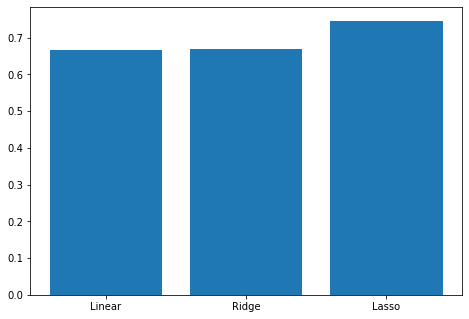

In [66]:
import matplotlib.pyplot as plt
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
mods = ['Linear', 'Ridge', 'Lasso']
scr = [s1,s2,s3]
ax.bar(mods,scr)
plt.show()

In summary, we have a fairly predictive linear model, which has the benefit of fast computation time over a large amount of data. This project can be extended further by providing a way for farmers to input data about their soil composition, in order to improve accuracy.